In [161]:
%run analyses/imports.py

### 제안 방법 사용 유무에 따른 모델 수행 시간 분석
- Execution Time (Wall-clock time)

In [163]:
'''
Usage:

- 'run_model_execution.py_reduction_rate.py' 실행 후 결과 파일의 경로 입력
- 아래 스크립트 실행
'''
src_file_msl = '/home/hwkang/dev-TSB-AD/TSB-AD/analyses/performance/kpca_msl_model_execution.csv'
src_file_smap = '/home/hwkang/dev-TSB-AD/TSB-AD/analyses/performance/kpca_smap_model_execution.csv'

df_msl = pd.read_csv(src_file_msl)
df_smap = pd.read_csv(src_file_smap)

In [164]:
def plot_model_execution(df, title=None):
    df = df.copy()
    df['time_distribution'] = df['time_distribution'].apply(eval)

    # 유니크 length와 use_kpca 값들
    lengths = sorted(df['length'].unique())
    kpca_values = sorted(df['use_kpca'].unique())

    # 색상과 간격 설정
    num_kpca = len(kpca_values)
    bar_width = 0.35
    positions = []
    box_data = []
    tick_labels = []

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, length in enumerate(lengths):
        for j, kpca in enumerate(kpca_values):
            subset = df[(df['length'] == length) & (df['use_kpca'] == kpca)]
            time_lists = subset['time_distribution'].tolist()

            if time_lists:
                # time_lists는 [[..], [..], ...] 구조
                box_data.append(time_lists)
                # 위치: length 별로 1 단위, 그 안에서 kpca별로 offset
                pos = i + (j - (num_kpca - 1) / 2) * bar_width
                positions.append(pos)

        tick_labels.append(str(length))

    print(len(positions))
    print(len(box_data))

    # boxplot: 리스트 안에 여러 시리즈가 들어갈 수 있도록 loop
    for data, pos in zip(box_data, positions):
        ax.boxplot(data, positions=[pos], widths=bar_width, patch_artist=True)

    # x축 눈금 위치 조정
    ax.set_xticks(range(len(lengths)))
    ax.set_xticklabels(tick_labels, rotation=45)
    ax.set_xlabel("Data Length")
    ax.set_ylabel("Execution Time")
    ax.set_yscale('log')
    ax.set_title(title or "Execution Time Distribution by Length and use_kpca")

    # 범례
    legend_patches = [
        plt.Line2D([0], [0], color='black', lw=0, marker='s', label=f'use_kpca={val}')
        for val in kpca_values
    ]
    ax.legend(handles=legend_patches, title='use_kpca', loc='lower right')

    plt.tight_layout()
    plt.show()

In [165]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

def plot_model_execution_v2(df, title=None, log_y=False):
    df = df.copy()
    df['time_distribution'] = df['time_distribution'].apply(eval)

    lengths = sorted(df['length'].unique())
    kpca_values = sorted(df['use_kpca'].unique())
    num_kpca = len(kpca_values)

    # 색상 매핑 정의 (예시)
    kpca_color_map = {
        kpca_values[0]: '#1f77b4',  # 파란색
        kpca_values[1]: '#ff7f0e',  # 주황색
    }

    bar_width = 0.35
    xticks = []
    xtick_labels = []

    fig, ax = plt.subplots(figsize=(14, 6))

    for i, length in enumerate(lengths):
        xtick_center = i
        median_positions = []  # ✅ 각 박스플롯의 (x, median_y) 저장용

        for j, kpca in enumerate(kpca_values):
            subset = df[(df['length'] == length) & (df['use_kpca'] == kpca)]
            times = [t for row in subset['time_distribution'] for t in row if t > 0]

            if times:
                pos = xtick_center + (j - (num_kpca - 1) / 2) * bar_width
                box = ax.boxplot(
                    [times],  # boxplot expects a 2D-like list
                    positions=[pos],
                    widths=bar_width,
                    patch_artist=True,
                    showfliers=False
                )
                for patch in box['boxes']:
                    patch.set_facecolor(kpca_color_map[kpca])
                for whisker in box['whiskers']:
                    whisker.set_color('black')
                for cap in box['caps']:
                    cap.set_color('black')
                for median in box['medians']:
                    median.set_color('black')
                    # ✅ median y 위치 추출
                    median_y = median.get_ydata()[0]
                    median_positions.append((pos, median_y))

        # ✅ 각 그룹의 median 선 그리기 (2개일 경우)
        if len(median_positions) == 2:
            (x1, y1), (x2, y2) = median_positions
            ax.plot([x1, x2], [y1, y2], color='red', linestyle=':', linewidth=1.8)

        xticks.append(xtick_center)
        xtick_labels.append(str(length))

    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels, rotation=45)
    # ✅ 그룹 경계선 추가
    for i in range(1, len(xticks)):
        x_prev = xticks[i - 1]
        x_curr = xticks[i]
        mid = (x_prev + x_curr) / 2
        ax.axvline(x=mid, color='gray', linestyle='--', linewidth=0.8)
    ax.set_xlabel("Data Length")
    ax.set_ylabel("Execution Time (s)")
    if log_y:
        ax.set_ylabel("Execution Time (s, log scale)")
        ax.set_yscale('log')
    ax.set_title(title or "Execution Time Distribution by Length and use_kpca")

    # 범례
    legend_patches = [
        mlines.Line2D([0], [0], color=color, marker='s', lw=0, label=f'use_kpca={True if val else False}')
        for val, color in kpca_color_map.items()
    ]
    ax.legend(handles=legend_patches, loc='lower right')

    plt.tight_layout()
    plt.show()


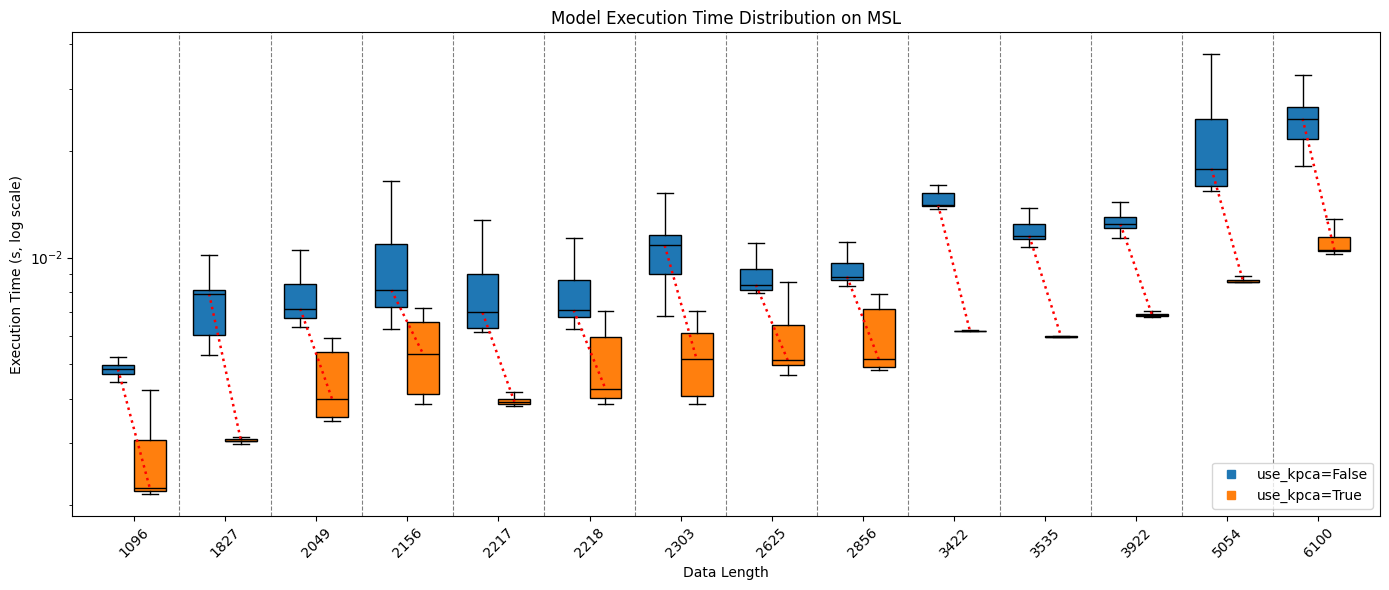

In [166]:
plot_model_execution_v2(df_msl, title="Model Execution Time Distribution on MSL", log_y=True)

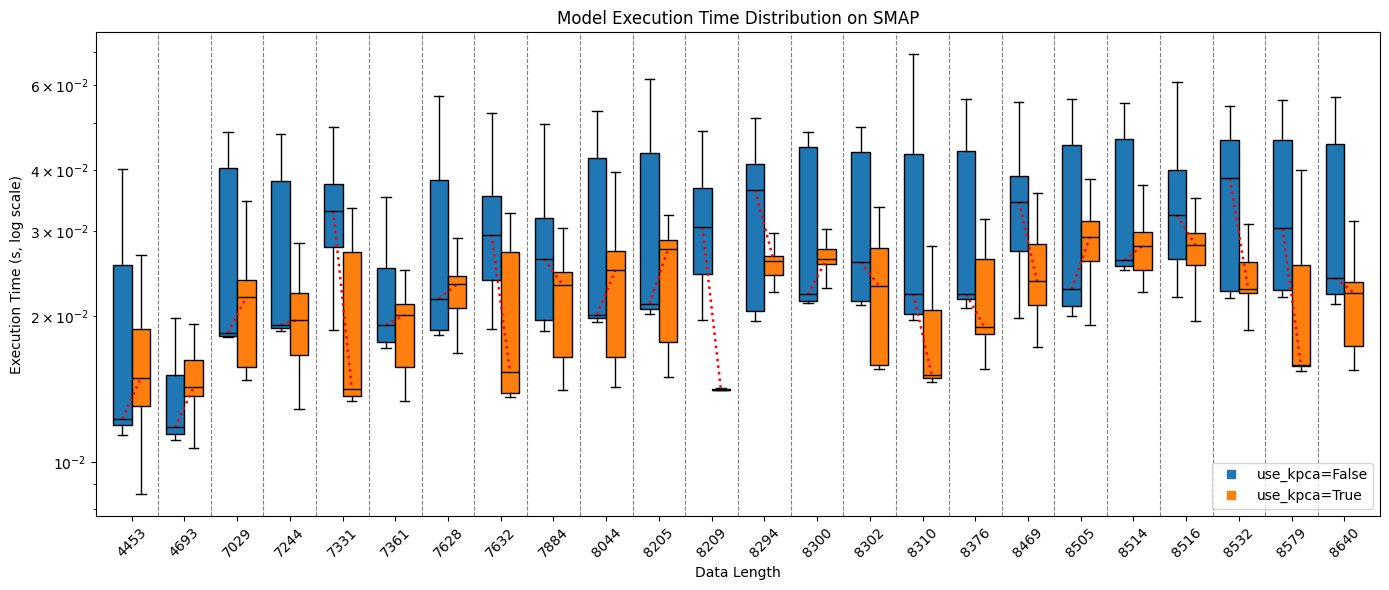

In [168]:
plot_model_execution_v2(df_smap, title="Model Execution Time Distribution on SMAP", log_y=True)